## CSE-4076 Assignment 6
Harish S 21MIA1046

## TASK 1

In [23]:
import cv2

# Load the video file
input_video_path = "TASK1.mp4"
video_capture = cv2.VideoCapture(input_video_path)

# Background subtractor for motion detection
motion_detector = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=25, detectShadows=True)

# Initialize variables for detection and tracking
tracked_region = None
reference_histogram = None
frame_index = 0

# Function to compute color histogram for appearance comparison
def compute_color_histogram(image, bounding_box):
    x_start, y_start, width, height = bounding_box
    roi = image[y_start:y_start + height, x_start:x_start + width]
    histogram = cv2.calcHist([roi], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(histogram, histogram)
    return histogram

# Function to compare histograms for appearance similarity
def compare_histograms(hist1, hist2, similarity_threshold=0.7):  # High threshold ensures stricter matches
    similarity_score = cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)
    return similarity_score > similarity_threshold

while video_capture.isOpened():
    success, current_frame = video_capture.read()
    if not success:
        break

    # Perform background subtraction periodically to update the mask
    if frame_index % 5 == 0:  # Update the mask every 5 frames
        foreground_mask = motion_detector.apply(current_frame)

        # Remove noise using morphological transformations
        morph_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        foreground_mask = cv2.morphologyEx(foreground_mask, cv2.MORPH_CLOSE, morph_kernel)

        # Detect contours in the mask
        detected_contours, _ = cv2.findContours(foreground_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        largest_area = 0
        optimal_bounding_box = None

        for contour in detected_contours:
            # Skip small objects
            contour_area = cv2.contourArea(contour)
            if contour_area < 1000:
                continue

            # Get the bounding box for the largest detected contour
            x, y, w, h = cv2.boundingRect(contour)

            # Check if this contour has the largest area
            if contour_area > largest_area:
                largest_area = contour_area
                optimal_bounding_box = (x, y, w, h)

        # Set up or update tracking using histogram comparison
        if optimal_bounding_box:
            if reference_histogram is None:
                # Initialize reference histogram
                reference_histogram = compute_color_histogram(current_frame, optimal_bounding_box)
                tracked_region = optimal_bounding_box
            else:
                # Compute the histogram of the current region and compare
                current_histogram = compute_color_histogram(current_frame, optimal_bounding_box)
                if compare_histograms(reference_histogram, current_histogram):
                    tracked_region = optimal_bounding_box

    # Draw a rectangle around the tracked person
    if tracked_region:
        x, y, w, h = tracked_region
        cv2.rectangle(current_frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(current_frame, "Target", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show the processed video frame
    cv2.imshow("Target Tracking", current_frame)
    frame_index += 1
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()


## TASK 2


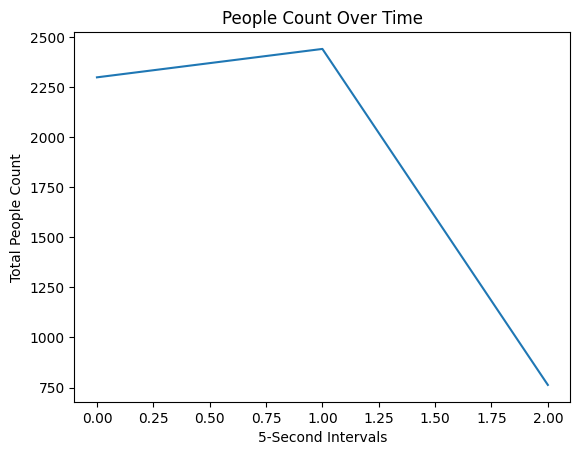

Peak shopping duration is in interval 1, with the highest count of people.


In [14]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# Set up directories for each step's output
os.makedirs('frames', exist_ok=True)
os.makedirs('differenced_frames', exist_ok=True)
os.makedirs('threshold_frames', exist_ok=True)
os.makedirs('detected_people', exist_ok=True)
os.makedirs('peak_frames', exist_ok=True)

# Load videoq
video = cv2.VideoCapture("task2.mp4")
fps = video.get(cv2.CAP_PROP_FPS)  # Frames per second (assumed 30 FPS)
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
interval = int(5 * fps)  # Interval of 5 seconds, i.e., 150 frames at 30 FPS

# Initialize Background Subtractor for stationary object detection
back_sub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=25, detectShadows=True)

# Step 1: Save Original Frames
frame_count = 0
people_count_per_frame = []
_, prev_frame = video.read()
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

while video.isOpened():
    ret, frame = video.read()
    if not ret:
        break
    
    # Save the original frame
    cv2.imwrite(f'frames/frame_{frame_count}.jpg', frame)
    
    # Step 2: Differencing for Motion Detection
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    diff_frame = cv2.absdiff(prev_gray, gray)
    cv2.imwrite(f'differenced_frames/diff_frame_{frame_count}.jpg', diff_frame)

    # Step 3: Apply Thresholding to Highlight Motion
    _, thresh = cv2.threshold(diff_frame, 25, 255, cv2.THRESH_BINARY)
    cv2.imwrite(f'threshold_frames/thresh_frame_{frame_count}.jpg', thresh)

    # Step 4: Background Subtraction for Stationary People Detection
    fg_mask = back_sub.apply(frame)
    _, fg_mask = cv2.threshold(fg_mask, 200, 255, cv2.THRESH_BINARY)
    dilated_fg = cv2.dilate(fg_mask, None, iterations=2)

    # Step 5: Contour Detection to Count People (Both Moving and Stationary)
    combined_mask = cv2.bitwise_or(thresh, dilated_fg)  # Combine motion and stationary masks
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    count = 0
    for c in contours:
        if cv2.contourArea(c) > 500:  # Filter small areas
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            count += 1

    people_count_per_frame.append(count)
    cv2.imwrite(f'detected_people/people_frame_{frame_count}.jpg', frame)
    
    prev_gray = gray
    frame_count += 1

# Step 6: Identify Peak Interval
people_count_per_interval = [
    sum(people_count_per_frame[i:i + interval]) for i in range(0, len(people_count_per_frame), interval)
]

# Plot the results
plt.plot(people_count_per_interval)
plt.xlabel('5-Second Intervals')
plt.ylabel('Total People Count')
plt.title('People Count Over Time')
plt.show()

# Find peak interval
peak_interval = np.argmax(people_count_per_interval)
print(f"Peak shopping duration is in interval {peak_interval}, with the highest count of people.")

# Step 7: Save Frames from Peak Interval for Visual Confirmation
peak_start_frame = peak_interval * interval
video.set(cv2.CAP_PROP_POS_FRAMES, peak_start_frame)

frame_count = 0
for _ in range(int(fps * 5)):  # Save frames for 5 seconds
    ret, frame = video.read()
    if not ret:
        break
    cv2.imwrite(f'peak_frames/peak_frame_{frame_count}.jpg', frame)
    frame_count += 1

# Cleanup
video.release()
cv2.destroyAllWindows()


## TASK 3


In [2]:
import cv2
import os

# Define paths for resources and outputs
reference_image_path = "task3.png"
input_video_path = 'Task3A.mp4'
processed_image_output = 'highlighted_reference_face.jpg'
processed_video_output = 'highlighted_faces_video.mp4'
face_output_directory = 'extracted_faces'

# Ensure the output directory for individual faces exists
os.makedirs(face_output_directory, exist_ok=True)

# Load the Haar Cascade classifier for face detection
face_detector = cv2.CascadeClassifier("haarcascade_frontalface_alt.xml")

# Function to detect faces and annotate the frame
def annotate_faces(frame, frame_id):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=4)
    face_index = 1  # Index for faces in the current frame

    for (x, y, w, h) in detected_faces:
        # Draw a rectangle around the detected face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Extract and save the individual face
        face_crop = frame[y:y + h, x:x + w]
        face_filename = os.path.join(face_output_directory, f"face_{frame_id}_#{face_index}.jpg")
        cv2.imwrite(face_filename, face_crop)
        face_index += 1

    return frame

# Process the reference image
reference_image = cv2.imread(reference_image_path)
if reference_image is not None:
    annotated_image = annotate_faces(reference_image, frame_id=0)  # Frame ID is 0 for the reference image
    cv2.imwrite(processed_image_output, annotated_image)
    cv2.imshow("Reference Image with Highlighted Face", cv2.resize(annotated_image, (600, 600)))

# Open the video file for processing
video_capture = cv2.VideoCapture(input_video_path)
video_width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
video_height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_rate = int(video_capture.get(cv2.CAP_PROP_FPS))

# Configure the video writer for output
video_codec = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(processed_video_output, video_codec, 1, (video_width, video_height))  # Output at 1 FPS

frame_number = 0  # Counter for frames read
saved_frames_count = 0  # Counter for frames saved to output video

while video_capture.isOpened():
    success, current_frame = video_capture.read()
    if not success:
        break

    # Process 1 frame per second
    if frame_number % frame_rate == 0:  # Process only 1 frame per second
        highlighted_frame = annotate_faces(current_frame, frame_id=saved_frames_count + 1)
        video_writer.write(highlighted_frame)

        # Display the current frame being processed
        resized_highlighted_frame = cv2.resize(highlighted_frame, (600, 600))
        cv2.imshow("Video Processing - Highlighted Faces", resized_highlighted_frame)
        saved_frames_count += 1
        print(f"Frame processed and saved: {saved_frames_count}")

    frame_number += 1  # Increment the total frame count

    # Press 'q' to stop the processing and exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

# Release video resources and clean up
video_capture.release()
video_writer.release()
cv2.destroyAllWindows()

print(f"Processing complete. Total frames saved: {saved_frames_count}")


Frame processed and saved: 1
Frame processed and saved: 2
Frame processed and saved: 3
Frame processed and saved: 4
Frame processed and saved: 5
Frame processed and saved: 6
Frame processed and saved: 7
Frame processed and saved: 8
Frame processed and saved: 9
Frame processed and saved: 10
Frame processed and saved: 11
Frame processed and saved: 12
Frame processed and saved: 13
Frame processed and saved: 14
Frame processed and saved: 15
Frame processed and saved: 16
Frame processed and saved: 17
Frame processed and saved: 18
Frame processed and saved: 19
Frame processed and saved: 20
Frame processed and saved: 21
Processing complete. Total frames saved: 21


## TASK 4

In [3]:
import cv2
import numpy as np

# Load the surveillance video
input_video_path = "TASK4.webm"  # Specify the correct video file path
video_capture = cv2.VideoCapture(input_video_path)

# Define the Region of Interest (ROI) dimensions
roi_x, roi_y = 100, 100  # Top-left corner of ROI
roi_width, roi_height = 250, 150  # Width and height of the ROI

# Set motion detection parameters
motion_area_threshold = 1200  # Minimum area for significant motion detection
entry_zone_y = int(roi_height * 0.7)  # Entry zone at 70% from the top of the ROI
exit_zone_y = int(roi_height * 0.3)  # Exit zone at 30% from the top of the ROI

# Initialize entry and exit counters
entry_counter = 0
exit_counter = 0
last_frame = None  # To hold the previous frame for motion comparison

# Process each frame in the video
while video_capture.isOpened():
    success, current_frame = video_capture.read()
    if not success:
        break

    # Convert the frame to grayscale and crop the ROI
    gray_frame = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    cropped_frame = gray_frame[roi_y:roi_y + roi_height, roi_x:roi_x + roi_width]

    # Initialize the last frame if it hasn't been set yet
    if last_frame is None:
        last_frame = cropped_frame
        continue

    # Compute frame difference to detect motion
    difference_frame = cv2.absdiff(last_frame, cropped_frame)
    _, binary_mask = cv2.threshold(difference_frame, 25, 255, cv2.THRESH_BINARY)
    last_frame = cropped_frame

    # Detect motion contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Analyze contours to determine entries and exits
    for contour in contours:
        if cv2.contourArea(contour) > motion_area_threshold:  # Ignore small motion areas
            bbox_x, bbox_y, bbox_w, bbox_h = cv2.boundingRect(contour)
            motion_center_y = bbox_y + bbox_h // 2  # Y-coordinate of motion's center

            # Check if motion is in the entry zone
            if motion_center_y > entry_zone_y:
                entry_counter += 1
            # Check if motion is in the exit zone
            elif motion_center_y < exit_zone_y:
                exit_counter += 1

            # Draw bounding box around detected motion
            cv2.rectangle(current_frame, 
                          (roi_x + bbox_x, roi_y + bbox_y), 
                          (roi_x + bbox_x + bbox_w, roi_y + bbox_y + bbox_h), 
                          (0, 255, 0), 2)

    # Draw the ROI rectangle on the frame
    cv2.rectangle(current_frame, (roi_x, roi_y), 
                  (roi_x + roi_width, roi_y + roi_height), (255, 0, 0), 2)

    # Overlay entry and exit counters on the video frame
    cv2.putText(current_frame, f"Entries: {entry_counter}", (20, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(current_frame, f"Exits: {exit_counter}", (20, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    # Display the frame with annotated ROI and counters
    cv2.imshow("Shop Entry/Exit Counter", current_frame)

    # Allow user to exit by pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release video resources and close the display window
video_capture.release()
cv2.destroyAllWindows()

# Print the final entry and exit counts
print("Final Entry Count:", entry_counter)
print("Final Exit Count:", exit_counter)


Final Entry Count: 30
Final Exit Count: 53


## TASK 5

In [4]:
import cv2
import os
import time
import pandas as pd
import random

# Create output directory
results_folder = "dwelling_time_results"
os.makedirs(results_folder, exist_ok=True)

# Load video
input_video_path = 'task5.mp4'  # Update with your video path
video_capture = cv2.VideoCapture(input_video_path)

# Initialize background subtractor
motion_detector = cv2.createBackgroundSubtractorMOG2()

# Data structures for tracking
entry_timestamps = {}      # Tracks entry time of detected entities
time_spent = {}            # Total time each entity spends in the ROI
tracked_positions = {}     # Keeps track of entity positions
entity_colors = {}         # Unique colors assigned to each entity
entity_id_counter = 1

# Function to associate detected objects with existing entities
def find_existing_entity(cx, cy, cw, ch):
    for entity_id, (ex, ey, ew, eh) in tracked_positions.items():
        if abs(cx - ex) < 50 and abs(cy - ey) < 50:  # Threshold for re-identification
            tracked_positions[entity_id] = (cx, cy, cw, ch)  # Update position
            return entity_id
    return None

# Function to generate a random color
def assign_random_color():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Process video frames
while video_capture.isOpened():
    ret, frame = video_capture.read()
    if not ret:
        break

    # Apply motion detection
    foreground_mask = motion_detector.apply(frame)
    _, threshold_mask = cv2.threshold(foreground_mask, 254, 255, cv2.THRESH_BINARY)

    # Detect contours for moving objects
    contours, _ = cv2.findContours(threshold_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Iterate over contours to detect and track entities
    for contour in contours:
        if cv2.contourArea(contour) < 500:
            continue

        # Bounding box for the detected contour
        x, y, w, h = cv2.boundingRect(contour)

        # Check if entity is already being tracked
        entity_id = find_existing_entity(x, y, w, h)
        if entity_id is None:
            # Assign new ID for a new entity
            entity_id = entity_id_counter
            entry_timestamps[entity_id] = time.time()  # Log entry time
            tracked_positions[entity_id] = (x, y, w, h)
            entity_colors[entity_id] = assign_random_color()
            entity_id_counter += 1

        # Calculate dwelling time
        duration_in_roi = time.time() - entry_timestamps[entity_id]
        time_spent[entity_id] = duration_in_roi

        # Annotate frame with bounding box, ID, and time
        color = entity_colors[entity_id]
        cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
        cv2.putText(frame, f"Time: {duration_in_roi:.1f}s", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.putText(frame, f"ID: {entity_id}", (x + w, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the processed frame
    cv2.imshow('Dwelling Time Tracker', frame)

    # Exit on 'q' key press
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

# Save the results to a CSV file
dwelling_time_data = [{'Entity ID': entity_id, 'Time in ROI (seconds)': duration} for entity_id, duration in time_spent.items()]
results_df = pd.DataFrame(dwelling_time_data)
results_df.to_csv(os.path.join(results_folder, 'dwelling_times.csv'), index=False)
print("Dwelling times saved to dwelling_times.csv.")

# Release resources
video_capture.release()
cv2.destroyAllWindows()


Dwelling times saved to dwelling_times.csv.


## TASK 6

In [5]:
import cv2
import os

# Path to the video
video_path = r"C:\Users\ASUS\Downloads\in.mp4"
output_folder = 'frames'

# Create a folder to save frames if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
else:
    frame_count = 0
    
    # Loop through each frame in the video
    while cap.isOpened():
        ret, frame = cap.read()
        
        # If a frame is returned
        if ret:
            # Define filename for each frame
            frame_filename = os.path.join(output_folder, f'frame_{frame_count:04d}.jpg')
            
            # Save the frame as an image file
            cv2.imwrite(frame_filename, frame)
            frame_count += 1
        else:
            break

    # Release the video capture object
    cap.release()
    print(f"Total frames saved: {frame_count}")


Total frames saved: 751


In [6]:
import cv2
import os

# Paths to input and output folders
input_folder = 'frames'
output_folder = 'detected_cars_frames'
os.makedirs(output_folder, exist_ok=True)

# Initialize background subtractor for motion detection
background_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

# Loop through the saved frames
for frame_file in sorted(os.listdir(input_folder)):
    frame_path = os.path.join(input_folder, frame_file)
    frame = cv2.imread(frame_path)

    # Check if frame is loaded successfully
    if frame is None:
        continue

    # Apply background subtraction
    fg_mask = background_subtractor.apply(frame)
    
    # Threshold the mask to binary to get clean detection areas
    _, fg_mask = cv2.threshold(fg_mask, 254, 255, cv2.THRESH_BINARY)

    # Find contours to detect moving cars
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected = False
    for cnt in contours:
        # Filter out small areas to ignore noise
        if cv2.contourArea(cnt) > 500:  # Adjust area threshold based on car size
            x, y, w, h = cv2.boundingRect(cnt)
            # Draw bounding box on the frame (optional for visualization)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            detected = True

    # If any cars were detected in the frame, save it
    if detected:
        output_path = os.path.join(output_folder, frame_file)
        cv2.imwrite(output_path, frame)

print("Car detection complete. Frames with detected cars are saved in:", output_folder)


Car detection complete. Frames with detected cars are saved in: detected_cars_frames


In [7]:
import cv2
import os
import numpy as np

# Paths to input and output folders
input_folder = 'frames'
output_folder = 'categorized_cars'
os.makedirs(output_folder, exist_ok=True)

# Initialize background subtractor
background_subtractor = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)

# Define color ranges for various colors
color_ranges = {
    "red": ((0, 100, 100), (10, 255, 255)),
    "orange": ((10, 100, 100), (25, 255, 255)),
    "yellow": ((25, 100, 100), (35, 255, 255)),
    "green": ((35, 50, 50), (85, 255, 255)),
    "cyan": ((85, 100, 100), (95, 255, 255)),
    "blue": ((95, 150, 0), (125, 255, 255)),
    "purple": ((125, 100, 100), (150, 255, 255)),
    "pink": ((150, 100, 100), (170, 255, 255)),
    "white": ((0, 0, 200), (180, 30, 255)),  # Bright area with low saturation
    "gray": ((0, 0, 50), (180, 20, 200)),    # Low saturation, moderate brightness
    "black": ((0, 0, 0), (180, 255, 50)),    # Very low brightness
}

# Process each saved frame
car_count = 0
for frame_file in sorted(os.listdir(input_folder)):
    frame_path = os.path.join(input_folder, frame_file)
    frame = cv2.imread(frame_path)

    if frame is None:
        continue

    # Apply background subtraction to detect moving objects
    fg_mask = background_subtractor.apply(frame)
    _, fg_mask = cv2.threshold(fg_mask, 254, 255, cv2.THRESH_BINARY)

    # Find contours of moving objects
    contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        # Filter out small contours to remove noise
        if cv2.contourArea(cnt) > 500:  # Adjust based on car size
            x, y, w, h = cv2.boundingRect(cnt)
            car_region = frame[y:y + h, x:x + w]

            # Convert to HSV for color-based classification
            hsv = cv2.cvtColor(car_region, cv2.COLOR_BGR2HSV)

            # Determine car color
            car_color = "unknown"
            for color_name, (lower, upper) in color_ranges.items():
                mask = cv2.inRange(hsv, lower, upper)
                if cv2.countNonZero(mask) > 500:  # Adjust threshold as needed
                    car_color = color_name
                    break

            # Save categorized frame with color label
            car_count += 1
            output_path = os.path.join(output_folder, f'{car_color}_car_{car_count:04d}.jpg')
            cv2.imwrite(output_path, car_region)

print("Car detection and categorization complete. Categorized frames are saved in:", output_folder)


Car detection and categorization complete. Categorized frames are saved in: categorized_cars


In [8]:
import cv2
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim

# Paths to input images and output folder for unique cars
input_folder = 'categorized_cars'
unique_folder = 'unique_cars'
os.makedirs(unique_folder, exist_ok=True)

# Set minimum dimensions for an image to be considered
min_width, min_height = 100, 100  # Adjust based on your images

# Threshold for SSIM similarity to consider two images as duplicates
similarity_threshold = 0.8

# Set a common size for all images for SSIM comparison
fixed_size = (200, 200)

# Function to check similarity between two images using SSIM
def are_images_similar(img1, img2, threshold=similarity_threshold):
    # Resize both images to the fixed size
    img1_resized = cv2.resize(img1, fixed_size)
    img2_resized = cv2.resize(img2, fixed_size)
    
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)
    
    # Compute SSIM between the resized grayscale images
    s = ssim(img1_gray, img2_gray)
    return s > threshold

# List to store unique images
unique_images = []
car_count = 0

# Process each image in the input folder
for image_file in sorted(os.listdir(input_folder)):
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path)

    # Skip images that are too small
    if image.shape[1] < min_width or image.shape[0] < min_height:
        continue

    # Compare with existing unique images
    is_unique = True
    for unique_image in unique_images:
        if are_images_similar(image, unique_image):
            is_unique = False
            break

    # If image is unique, add it to the unique images list and save it
    if is_unique:
        unique_images.append(image)
        car_count += 1
        output_path = os.path.join(unique_folder, f'unique_car_{car_count:04d}.jpg')
        cv2.imwrite(output_path, image)

print(f"Unique car detection complete. Total unique cars counted: {car_count}")
print("Unique car images are saved in:", unique_folder)


Unique car detection complete. Total unique cars counted: 535
Unique car images are saved in: unique_cars


In [9]:
import cv2
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans

# Paths to the input and output folders
input_folder = 'unique_cars'
distinct_folder = 'distinct_cars'
os.makedirs(distinct_folder, exist_ok=True)

# Threshold for SSIM similarity to consider two images as duplicates
similarity_threshold = 0.4

# Minimum dimensions for an image to be considered distinct
min_width, min_height = 200, 150

# Set a common size for all images for SSIM comparison
fixed_size = (200, 200)

# Define a threshold for color similarity (Euclidean distance in RGB space)
color_similarity_threshold = 50

# Function to get the dominant color of an image
def get_dominant_color(image, k=1):
    # Resize image to speed up processing
    img = cv2.resize(image, (100, 100))
    img = img.reshape((-1, 3))

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(img)
    dominant_color = kmeans.cluster_centers_[0]
    return dominant_color

# Function to check similarity between two images using SSIM
def are_images_similar(img1, img2, threshold=similarity_threshold):
    # Resize both images to the fixed size
    img1_resized = cv2.resize(img1, fixed_size)
    img2_resized = cv2.resize(img2, fixed_size)
    
    # Convert images to grayscale
    img1_gray = cv2.cvtColor(img1_resized, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_resized, cv2.COLOR_BGR2GRAY)
    
    # Compute SSIM between the resized grayscale images
    s = ssim(img1_gray, img2_gray)
    return s > threshold

# Function to calculate the Euclidean distance between two RGB colors
def color_distance(color1, color2):
    return np.linalg.norm(color1 - color2)

# List to store unique images and their dominant colors
distinct_images = []
distinct_colors = []
distinct_count = 0

# Process each image in the unique_cars folder
for image_file in sorted(os.listdir(input_folder)):
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path)

    # Skip images that are smaller than the specified dimensions
    if image.shape[1] < min_width or image.shape[0] < min_height:
        continue

    # Calculate the dominant color of the current image
    dominant_color = get_dominant_color(image)

    # Compare with existing distinct images
    is_distinct = True
    for i, distinct_image in enumerate(distinct_images):
        # Check if images are similar based on SSIM
        if are_images_similar(image, distinct_image):
            # Check if dominant colors are also similar
            if color_distance(dominant_color, distinct_colors[i]) < color_similarity_threshold:
                is_distinct = False
                break

    # If image is distinct, add it to the distinct images list and save it
    if is_distinct:
        distinct_images.append(image)
        distinct_colors.append(dominant_color)
        distinct_count += 1
        output_path = os.path.join(distinct_folder, f'distinct_car_{distinct_count:04d}.jpg')
        cv2.imwrite(output_path, image)

print(f"Filtering complete. Total distinct cars saved: {distinct_count}")
print("Distinct car images are saved in:", distinct_folder)


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Filtering complete. Total distinct cars saved: 64
Distinct car images are saved in: distinct_cars


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [10]:
import cv2
import os
import numpy as np
from sklearn.cluster import KMeans

# Paths to input folder and output folder for unique color cars
input_folder = 'distinct_cars'
output_folder = 'unique_color_cars'
os.makedirs(output_folder, exist_ok=True)

# Define a threshold for color similarity (Euclidean distance in RGB space)
color_similarity_threshold = 50

# Function to get the dominant color of an image
def get_dominant_color(image, k=1):
    # Resize image to speed up processing
    img = cv2.resize(image, (100, 100))
    img = img.reshape((-1, 3))

    # Apply k-means clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(img)
    dominant_color = kmeans.cluster_centers_[0]
    return dominant_color

# Function to calculate the Euclidean distance between two RGB colors
def color_distance(color1, color2):
    return np.linalg.norm(color1 - color2)

# List to store unique colors and their corresponding images
unique_colors = []
car_count = 0

# Process each image in the distinct_cars folder
for image_file in sorted(os.listdir(input_folder)):
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path)

    # Calculate the dominant color of the current image
    dominant_color = get_dominant_color(image)

    # Check if this dominant color is similar to any previously saved unique color
    is_unique_color = True
    for color in unique_colors:
        if color_distance(dominant_color, color) < color_similarity_threshold:
            is_unique_color = False
            break

    # If the color is unique, save the image and add the color to the list
    if is_unique_color:
        unique_colors.append(dominant_color)
        car_count += 1
        output_path = os.path.join(output_folder, f'unique_color_car_{car_count:04d}.jpg')
        cv2.imwrite(output_path, image)

print(f"Color-based filtering complete. Total unique color cars saved: {car_count}")
print("Unique color car images are saved in:", output_folder)


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 

Color-based filtering complete. Total unique color cars saved: 4
Unique color car images are saved in: unique_color_cars


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
 